# MosMedData: 新冠肺炎胸部 CT扫描数据集上基于3D-CNN实现二分类

作者: [WangXi2016](https://github.com/WangXi2016)

日期: 2022.10.27

摘要: 本示例教程使用3D CNN实现CT数据二分类。

## 1、介绍

![](https://ai-studio-static-online.cdn.bcebos.com/925198dd28884de78b0563807b7fed3c92648e052b314f5fa419b495e4c8d5dd)

本示例将展示构建3D卷积神经网络（3D CNN），以预测电子计算机断层扫描（CT）是否感染新冠病毒肺炎。

2D CNN通常用于处理RGB图像（3个通道）。

3D CNN：它将3D数据或2D帧序列（例如CT扫描中的切片）作为输入，这个架构可以从3D深度或者连续视频帧中产生多通道的信息，然后在每一个通道都分离地进行卷积和下采样操作。最后将所有通道的信息组合起来得到最终的特征描述。

## 2、解压数据集

完整数据集链接：https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1

In [ ]:
import os
# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("data/data112472/ct-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("data/data112472/ct-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

## 3、导入相关库

In [ ]:
!pip install nibabel -t /home/aistudio/external-libraries
!pip install scipy -t /home/aistudio/external-libraries

In [1]:
import os
import zipfile
import numpy as np

import paddle
import paddle.nn as nn
from paddle.io import Dataset
import random

import sys 
sys.path.append('/home/aistudio/external-libraries')

paddle.__version__

'2.3.2'

## 4、加载数据和预处理


我们将使用CT扫描的相关放射学发现作为标签来构建分类器，来预测新冠病毒肺炎是否存在。因此，该任务是一个二分类问题。

这些文件以Nifti格式提供，扩展名为.nii。为了读取扫描，我们通过安装该软件包。CT扫描以Hounsfield单位（HU）存储原始体素强度。在这个数据集中，它们的范围从-1024到2000以上。400以上是具有不同放射性强度的骨头，因此这被用作更高的界限。1000到400之间的阈值通常用于标准化CT扫描。


为了处理数据，我们执行以下操作：


首先将体积旋转90度，因此方向是固定的

将HU值缩放为介于0和1之间。

调整宽度、高度和深度。

这里我们定义了几个帮助函数来处理数据，这些功能将用于构建训练和验证数据集。

In [2]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

**从类目录中读取 CT 扫描的路径。**

In [3]:
# 文件夹“CT-0”包括具有正常肺组织的CT扫描，
# 没有病毒性肺炎的CT。
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x)
    for x in os.listdir("MosMedData/CT-0")
]

#文件夹“CT-23”包括具有感染的CT扫描，

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


## 5、构建训练和验证数据集
从数据集目录中读取扫描并分配标签。

对扫描结果进行缩减采样，使其形状为 128x128x64。

将原始 HU 值重新缩放到 0 到 1 的范围。最后，将数据集拆分为训练子集和验证子集。

In [4]:
import os
abnormal_path = "abnormal_scans.npy"
normal_path = "normal_scans.npy"
# 因此处转换比较耗时，故缓存一下
if os.path.exists(abnormal_path) and os.path.exists(normal_path):
    abnormal_scans = np.load(abnormal_path)
    normal_scans = np.load(normal_path)
else:
    abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
    normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
    np.save(abnormal_path,abnormal_scans)
    np.save(normal_path,normal_scans)



CT扫描还通过在训练期间以随机角度旋转来增强。由于数据存储在形状的 rank-3 张量中，我们在轴 4 处添加一个大小为 1 的维度，以便能够对数据执行 3D 卷积。

In [5]:
import random
# 定义数据读取器
class dataset(Dataset):
    def __init__(self, abnormal_scans,normal_scans, mode='train'):
        super().__init__()
        self.imgs = []
        self.labels = []
        self.train = False
        abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
        normal_labels = np.array([0 for _ in range(len(normal_scans))])
        if mode == 'train':
            x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
            y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
            self.imgs = x_train
            self.labels = y_train
            self.train = True

        else:
            x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
            y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
            self.imgs = x_val
            self.labels = y_val
            


    def __getitem__(self, index):
        """
        获取一组数据
        :param index: 文件索引号
        :return:
        """
        img = self.imgs[index]
        lab = self.labels[index]
        if self.train:
            img = self.rotate(img)
        img = np.array(img).astype('float32')
        lab = np.array([lab], dtype="int64")
        img = np.expand_dims(img,3)
        return img, lab



    def __len__(self):
        return len(self.labels)

    def rotate(self,volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

In [6]:
train_dataset = dataset(abnormal_scans,normal_scans)
validation_dataset= dataset(abnormal_scans,normal_scans,mode='val')

train_loader = paddle.io.DataLoader(train_dataset, batch_size=10, shuffle=True)
validation_loader = paddle.io.DataLoader(validation_dataset, batch_size = 10, shuffle=False)

**可视化增强型 CT 扫描。**

(128, 128, 64, 1)
Dimension of the CT scan is: (128, 128, 64)


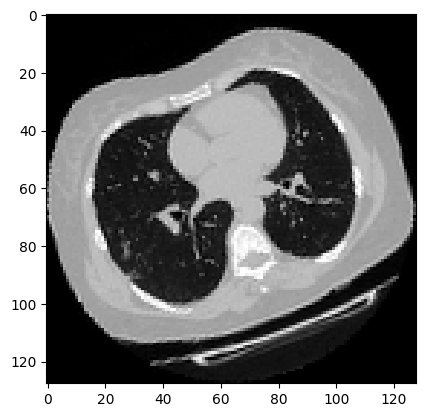

In [20]:
import matplotlib.pyplot as plt


images, labels  = train_dataset.__getitem__(0)
print(images.shape)
image =np.squeeze(images, 3)
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")
plt.show()

**由于CT扫描有许多层切片，可视化多层切片。**

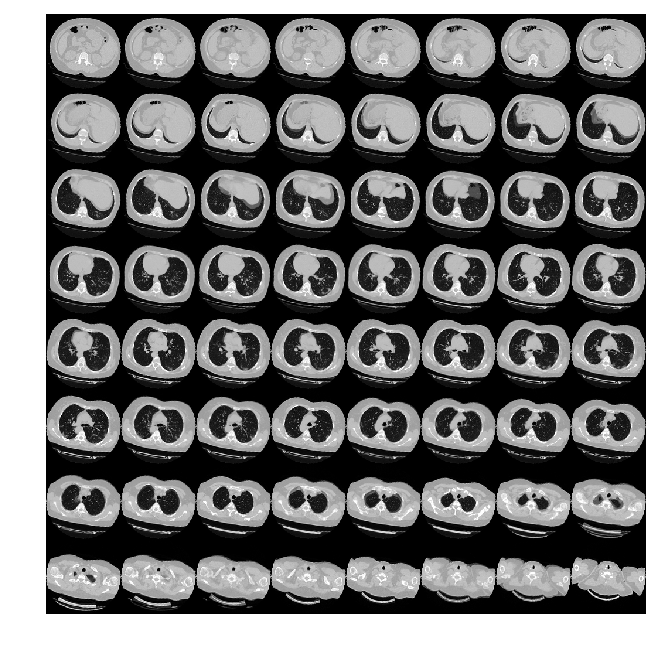

In [14]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 64 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 6.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(8, 8, 128, 128, image[:, :, :64])

## 6、定义 3D 卷积神经网络

当我们说卷积神经网络（CNN）时，通常是指用于图像分类的二维CNN。但是，现实世界中还使用了其他两种类型的卷积神经网络，即1维CNN和3维CNN。在本指南中，我们将介绍1D和3D CNN及其在现实世界中的应用。我假设您已经大体上熟悉卷积网络的概念。
初学者可能会理解为1维CNN处理一维的数据，2维CNN处理二维的数据，这是错误的！！！

在卷积神经网络（CNN）中，一维和二维滤波器并不是真正的一维和二维。这是只是描述的惯例。

### 二维CNN | Conv2D
在Lenet-5架构中首次引入的标准卷积神经网络，其Conv2D通常用于图像数据。之所以称其为2维CNN，是因为内核在数据上沿2维滑动，如下图所示。
![](https://ai-studio-static-online.cdn.bcebos.com/bc6e92642e9240c3a91d68cce45dc5fadfda802d94304231ac23c0610921754d)


内核在图像上滑动

使用CNN的整体优势在于，它可以使用其内核从数据中提取空间特征，而其他网络则无法做到。例如，CNN可以检测图像中的边缘，颜色分布等，这使得这些网络在图像分类和包含空间属性的其他类似数据中非常强大。

### 一维CNN | Conv1D
在介绍Conv1D之前，首先给出一个提示。即在Conv1D中，内核沿一维滑动。现在，让我们在此处暂停，考虑哪种类型的数据仅需要内核在一个维度上滑动并具有空间特性？
答案是时间序列数据。让我们看一下以下数据。

![](https://ai-studio-static-online.cdn.bcebos.com/cd99c2901bf240fd86b196f3d1c0fdc06a7c68b8b0c74cb9844f060a9d350d74)

来自加速度计的序列数据

该数据是从人戴在手臂上的加速度计中收集的。数据表示所有三个轴的加速度。一维CNN可以根据加速度计数据执行活动识别任务，例如人的身姿，行走，跳跃等。此数据有2个维度。第一维是时间步长，其他维是3轴上的加速度值。
下图说明了内核如何在加速度计数据上移动。每行代表某个轴的时间序列加速度。内核只能沿时间轴一维移动。
![](https://ai-studio-static-online.cdn.bcebos.com/abd0bd4caf2f426d8321338470823b81f8561290bc924181b3939bc9abd6b8e4)

Conv1D广泛应用于感官数据，加速度计数据就是其中之一。

### 三维CNN | Conv3D
在Conv3D中，内核按3个维度滑动，如下所示。让我们再考虑一下哪种数据类型需要内核在3维上移动？
![](https://ai-studio-static-online.cdn.bcebos.com/255e649129b1477f8febaf460b6cfec6efb541b92deb4dae8e0ea870aef8c0c0)

内核在3D数据上滑动

Conv3D主要用于3D图像数据。例如磁共振成像（MRI）数据。MRI数据被广泛用于检查大脑，脊髓，内部器官等。
还有本案例，甲计算机断层扫描（CT）扫描也是三维数据，这是通过组合从身体周围的不同角度拍摄的一系列X射线图像。
我们可以使用Conv3D对该医学数据进行分类或从中提取特征。



基于Layer定义模型网络结构，模型的可视化展示。

In [7]:

# 3D CNN网络
class CNN3D(nn.Layer):
    def __init__(self):
        super(CNN3D, self).__init__()     
        self.con1 = nn.Conv3D(in_channels=1,out_channels=64,kernel_size=3)
        self.con2 = nn.Conv3D(in_channels=64,out_channels=64,kernel_size=3)
        self.con3 = nn.Conv3D(in_channels=64,out_channels=128,kernel_size=3)
        self.con4 = nn.Conv3D(in_channels=128,out_channels=256,kernel_size=3)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm3D(num_features=64)
        self.bn2 = nn.BatchNorm3D(num_features=64)
        self.bn3 = nn.BatchNorm3D(num_features=128)
        self.bn4 = nn.BatchNorm3D(num_features=256)
        self.maxpool = nn.MaxPool3D(kernel_size=2)
        self.globalave= nn.AvgPool3D((2,6,6))
        self.line1 = nn.Linear(256,512)
        self.line2 = nn.Linear(512,1)
        self.sig = nn.Sigmoid()
        self.drop= nn.Dropout(p=0.3)

    def forward(self, inputs):
        # 因为数据输入是 【批次、宽度、高度、深度、通道】，调整Paddle默认输入要求，【批次、通道、深度、宽度、高度】
        inputs = inputs.transpose((0,4,3,1,2))
        
        x = self.relu(self.con1(inputs))
        x = self.maxpool(x)
        x = self.bn1(x)
        
        x = self.relu(self.con2(x))
        x = self.maxpool(x)
        x = self.bn2(x)
   
        x = self.bn3(self.maxpool(self.relu(self.con3(x))))
        x = self.bn4(self.maxpool(self.relu(self.con4(x))))
        x = self.globalave(x)
        x= x.reshape((x.shape[0], -1))
        x = self.relu(self.line1(x))
        x = self.drop(x)
        x = self.sig(self.line2(x))
        return x
        
        

In [9]:
cnn = CNN3D()
paddle.summary(cnn,(1,128,128,64,1))


W1027 12:01:54.666692   335 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1027 12:01:54.671041   335 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


------------------------------------------------------------------------------
 Layer (type)        Input Shape           Output Shape          Param #    
   Conv3D-1     [[1, 1, 64, 128, 128]] [1, 64, 62, 126, 126]      1,792     
    ReLU-1            [[1, 512]]             [1, 512]               0       
  MaxPool3D-1   [[1, 256, 4, 12, 12]]    [1, 256, 2, 6, 6]          0       
 BatchNorm3D-1  [[1, 64, 31, 63, 63]]   [1, 64, 31, 63, 63]        256      
   Conv3D-2     [[1, 64, 31, 63, 63]]   [1, 64, 29, 61, 61]      110,656    
 BatchNorm3D-2  [[1, 64, 14, 30, 30]]   [1, 64, 14, 30, 30]        256      
   Conv3D-3     [[1, 64, 14, 30, 30]]  [1, 128, 12, 28, 28]      221,312    
 BatchNorm3D-3  [[1, 128, 6, 14, 14]]   [1, 128, 6, 14, 14]        512      
   Conv3D-4     [[1, 128, 6, 14, 14]]   [1, 256, 4, 12, 12]      884,992    
 BatchNorm3D-4   [[1, 256, 2, 6, 6]]     [1, 256, 2, 6, 6]        1,024     
  AvgPool3D-1    [[1, 256, 2, 6, 6]]     [1, 256, 1, 1, 1]          0     

{'total_params': 1352897, 'trainable_params': 1350849}

## 7、训练模型

使用前面构建的3D CNN和数据集进行模型训练。

我们这个是二分类任务，网络的最后输出是一个0-1之间的浮点数，所以我们这边使用BCE损失。

In [14]:

def Accuracy(pre,label):
    a = np.squeeze(pre.cpu().numpy(), -1)
    a = a<0.5
    b = np.squeeze(label.cpu().numpy(), -1)==0
    c = np.sum(a==b)
    return c / len(a)

scheduler = paddle.optimizer.lr.ExponentialDecay(learning_rate=0.0001, gamma=0.96, verbose=True)
optim = paddle.optimizer.AdamW(learning_rate=scheduler,parameters=cnn.parameters())
criterion = paddle.nn.BCELoss()
num_epochs = 30
max_accuracy = 0
save_path ="best3dcnn"
his_trainloss = []
his_trainacc = []
his_valloss = []
his_valacc = []
for epoch in range(num_epochs):
    
    traintotal,trainacc,trainloss = 0, 0, 0
    cnn.train()
    for i, (img, labels) in enumerate(train_loader):     
        predict = cnn(img)
        loss = criterion(predict, labels.astype(np.float32))
        optim.clear_grad()
        loss.backward()
        optim.minimize(loss)
        acc = Accuracy(predict, labels)
        trainacc += acc
        trainloss += loss.numpy()
        if i%10==0:
            print(f"epoch {epoch} iter {i} loss: {loss.numpy()}, accuracy {acc}")
        traintotal += 1
    valtotal, valacc,valloss = 0, 0, 0
    cnn.eval()
    for i ,(img, labels) in enumerate(validation_loader):
        with paddle.no_grad():
            predict = cnn(img)
            loss = criterion(predict, labels.astype(np.float32))
        valacc +=Accuracy(predict, labels)
        valloss += loss.numpy()
        valtotal+=1
    print(f"epoch {epoch} val Loss {valloss/valtotal} Accuray {valacc/valtotal} ")   
    # 只保存最优模型
    if valacc/valtotal>max_accuracy:
        max_accuracy = valacc/valtotal
        model_state = cnn.state_dict()
        paddle.save(model_state, save_path)
        print("max accuracy {}".format(max_accuracy))
    scheduler.step()
    his_trainloss.append(trainloss/traintotal)
    his_trainacc.append(trainacc/traintotal)
    his_valloss.append(valloss/valtotal)
    his_valacc.append(valacc/valtotal)
    

Epoch 0: ExponentialDecay set learning rate to 0.0001.
epoch 0 iter 0 loss: [0.47805202], accuracy 0.9
epoch 0 iter 10 loss: [0.50222117], accuracy 0.9
epoch 0 val Loss [0.6534414] Accuray 0.5499999999999999 
max accuracy 0.5499999999999999
Epoch 1: ExponentialDecay set learning rate to 9.6e-05.
epoch 1 iter 0 loss: [0.40284893], accuracy 0.8
epoch 1 iter 10 loss: [0.69401467], accuracy 0.5
epoch 1 val Loss [0.6254799] Accuray 0.5666666666666667 
max accuracy 0.5666666666666667
Epoch 2: ExponentialDecay set learning rate to 9.216e-05.
epoch 2 iter 0 loss: [0.39504746], accuracy 0.8
epoch 2 iter 10 loss: [0.42998612], accuracy 0.9
epoch 2 val Loss [0.60735255] Accuray 0.55 
Epoch 3: ExponentialDecay set learning rate to 8.847359999999999e-05.
epoch 3 iter 0 loss: [0.48826373], accuracy 0.7
epoch 3 iter 10 loss: [0.3566341], accuracy 0.9
epoch 3 val Loss [0.60325307] Accuray 0.7000000000000001 
max accuracy 0.7000000000000001
Epoch 4: ExponentialDecay set learning rate to 8.4934655999999

## 8、可视化模型性能

> 这里绘制了训练和验证集的模型精度和损失。
> 
> 由于验证集是类平衡的，准确率可以无偏见表示模型性能。

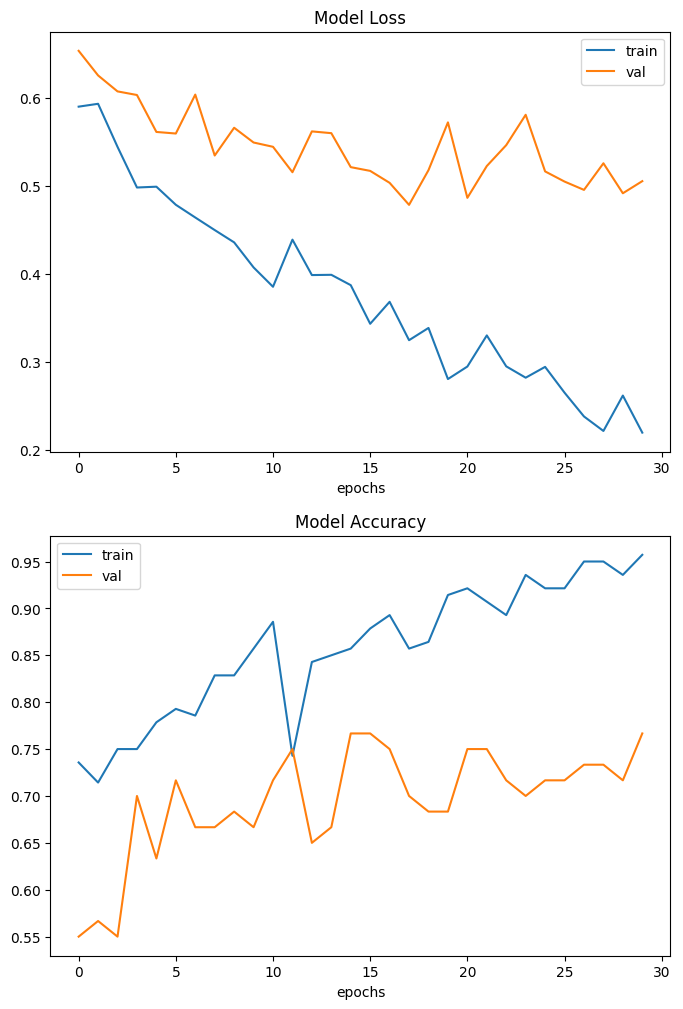

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(8, 12))
ax = ax.ravel()


ax[0].plot(his_trainloss)
ax[0].plot(his_valloss)
ax[0].set_title("Model {}".format("Loss"))
ax[0].set_xlabel("epochs")
ax[0].legend(["train", "val"])

ax[1].plot(his_trainacc)
ax[1].plot(his_valacc)
ax[1].set_title("Model {}".format("Accuracy"))
ax[1].set_xlabel("epochs")
# ax[1].set_ylabel(metric)
ax[1].legend(["train", "val"])

需要注意的是，样本的数量非常少只有200个。

因此，验证集与训练集中预测结果有显著差异。[这里可以找到由1000多个CT扫描组成的完整数据集。](https://www.medrxiv.org/content/10.1101/2020.05.20.20100362v1)

使用完整的数据集，准确率达到83%。

在这两种情况下，分类性能的变异性均为6-7%。

## 9、模型预测
对模型进行预测，展示效果。

In [22]:
param_state_dict = paddle.load( "Brain1")
cnn.set_dict(param_state_dict)
cnn.eval() #预测模式
def prediction(index):
    imagen,label = validation_dataset.__getitem__(index)
    image = paddle.to_tensor(np.expand_dims(imagen, axis=0), dtype=paddle.float32)
    prediction = cnn(image)
    scores = [1 - prediction[0][0], prediction[0][0]]
    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "模型预测： %.2f 概率，这张CT %s"
            % ((100 * score), name)
        )
    print("真实标签为：",class_names[int(label[0])])
    data = np.rot90(imagen)
    data = np.transpose(data)
    data = np.reshape(data, (8, 8, 128, 128))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 6.0
    fig_height = fig_width * sum(heights) / sum(widths)

    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )

    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

    plt.text(-930,-850 , "The true label is:"+class_names[int(label[0])], size = 15,\
            family = "微软雅黑", color = "yellow", style = "italic", weight = "light",\
            bbox = dict(facecolor = "black", alpha = 0.3))  
    plt.text(-930,-790 , "This model is %.2f percent confident that CT scan is %s"% ((100 * scores[0]),class_names[0]), size = 15,\
            family = "微软雅黑", color = "w", style = "italic", weight = "light",\
            bbox = dict(facecolor = "black", alpha = 0.3))  
    plt.text(-930,-730 , "This model is %.2f percent confident that CT scan is %s"% ((100 * scores[1]),class_names[1]), size = 15,\
            family = "微软雅黑", color = "r", style = "italic", weight = "light",\
            bbox = dict(facecolor = "black", alpha = 0.3)) 
    plt.show()


模型预测： 23.98 概率，这张CT normal
模型预测： 76.02 概率，这张CT abnormal
真实标签为： abnormal


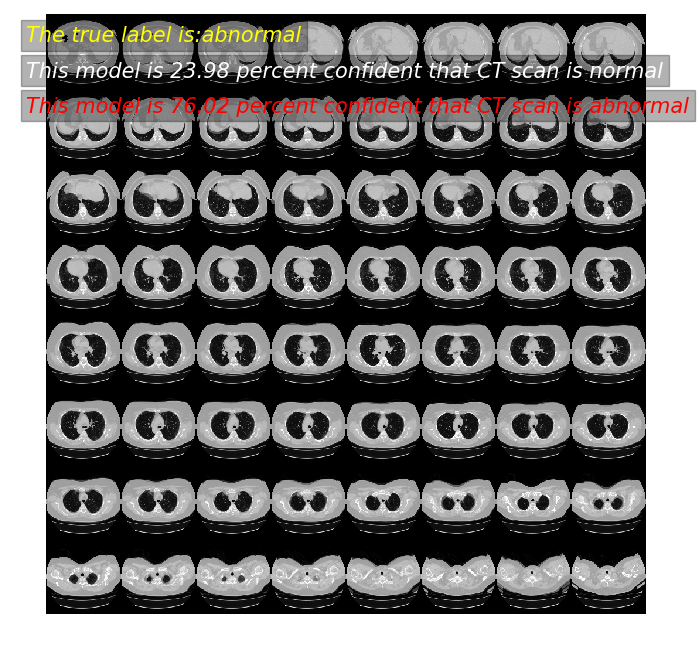

In [24]:
prediction(2)

模型预测： 25.95 概率，这张CT normal
模型预测： 74.05 概率，这张CT abnormal
真实标签为： abnormal


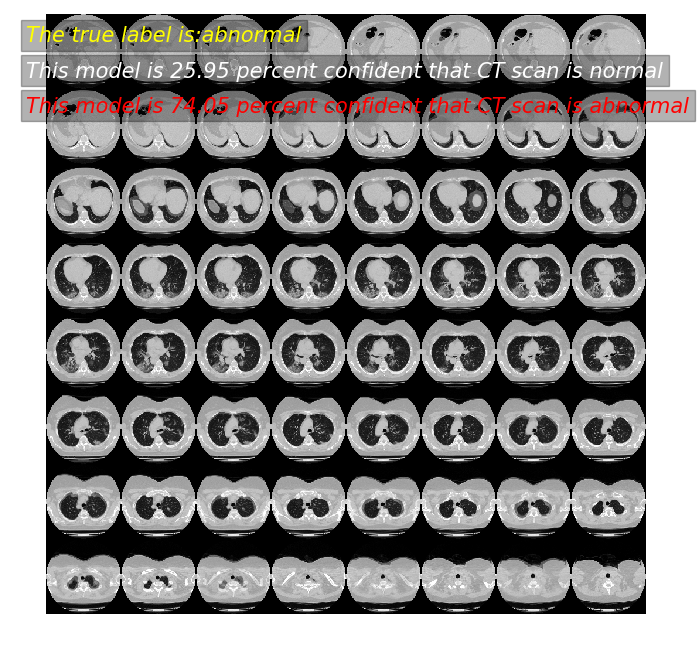

In [25]:
prediction(11)

模型预测： 79.78 概率，这张CT normal
模型预测： 20.22 概率，这张CT abnormal
真实标签为： normal


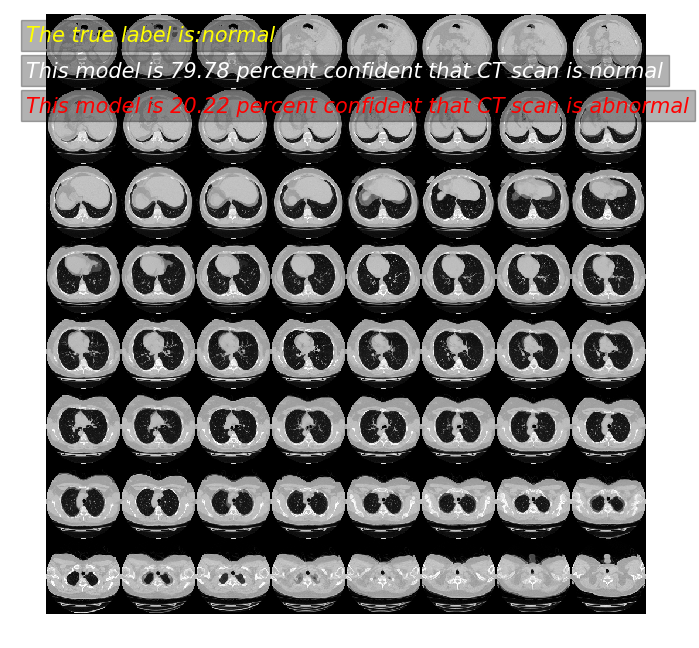

In [27]:
prediction(55)